In [1]:
from IPython.display import IFrame
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from scipy.stats import poisson, entropy
from scipy import optimize

# Defintions

In [2]:
column_width = 246 * 0.0138 # inch
column_sep = 18 * 0.0138 # inch
n_columns = 2
full_width = n_columns * column_width + column_sep
ratio_1_col = 0.75
ratio_2_col = 0.75

title_size = 8
font_size = 7
axs_text_size = 'xx-large'
legend_column_spacing = 10
legend_width = 30

linewidth = 0.6

markersize = 3
marker_dict = {"aml":'v',
               "entropy_gain":'+',
               "minbins":'o',
               "hmm":'s',
               "hmm_no_exp":'o'}

color_dict =  {"aml":'r',
               "entorpy_gain":'g',
               "minbins":'b',
               "hmm":'c',
               "hmm_no_exp":'m'}

label_dict =  {"aml":'AML',
               "entropy_gain":'entropy gain',
               "minbins":'minimum bins',
               "hmm":'Markov MAP',
               "hmm_no_exp":'Markov MAP (constant threshold)'}


# data path
path='./data/'

# Figure 1: Entropy expectation difference

In [3]:
def binary_entropy(p, epsilon=0.01, n=100):
    if (p < epsilon or p > 1 - epsilon):
        # use Taylor
        ## x (log(x) - 1) / log(2) + x^2 / log(4) + (1/log(64))x^3 + (1/log(4096))x^4 + (1/20log(2))x^5 + O(x^6)
        ## xlog(x) = -x sum_k=1^n ((-1)^k (1 - x)^k) / k
        x = p
        if (p > 0.5):
            x = 1 - p
        # xlog(x) term
        term1 = 0
        for i in range(n):
            # start with the smallest term, then we also automatically abort for k=1.
            # We start with the smallest term such that we do not run into numerical issues
            # adding floats with wildly different exponents.
            # we need a huge n! Convergence is bad...
            k = n-i
            term1+=(((-1.0)**k * (-1.0 + x)**k)/k)   
        term1*= -x
        
        # term 2
        term2= -x + x**2/2.0 + x**3/6.0 + x**4/12.0 + x**5/20.0
        return -(term1 + term2)/np.log(2)
        
    else:
        # use scipy
        return entropy([p, 1-p], base=2)
    
def entropy_diff_n(mu_D, mu_B, p_b, n):
    p_i_dark = poisson.pmf(n, mu_D)
    p_i_bright = poisson.pmf(n, mu_B)

    # no Pi
    p_D_no_Pi = (1 - p_b) * p_i_dark
    p_B_no_Pi = p_b * p_i_bright

    # pi
    p_D_Pi = (1 - p_b) * p_i_bright
    p_B_Pi = p_b * p_i_dark

    # check for numerical issues, like, uh, dividing by 0...
    s_Pi = p_D_Pi+p_B_Pi
    if s_Pi == 0:
        p_Pi = 0
    else:
        p_Pi = p_D_Pi / (p_D_Pi+p_B_Pi)
    
    s_no_Pi = p_D_no_Pi+p_B_no_Pi
    if s_no_Pi == 0:
        p_no_Pi = 0
    else:
        p_no_Pi = p_D_no_Pi / s_no_Pi
    # return weighted difference
    return (p_i_dark + p_i_bright) * (binary_entropy(p_Pi) - binary_entropy(p_no_Pi))

def entropy_diff(p_b, mu_D, mu_B, n_max):
    H_diff = 0
    for i in range(n_max):
        # add
        H_diff_n_weighted = entropy_diff_n(mu_D, mu_B, p_b, i)
        H_diff+= H_diff_n_weighted
        
    return H_diff

1.0


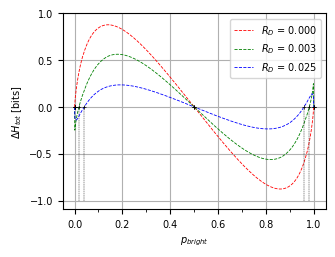

In [4]:
# Figure 1: entropy gain decision boundaries

n_bins = 20
t_bin = 200 / n_bins
R_D = (0, 0.5/200, 5/200)
R_B =  25 / 200

# plot settings
plt.rc('font', size=font_size)  
plt.rc('axes', titlesize=title_size)
fig, ax = plt.subplots(1, 1, figsize=(column_width,0.75 * column_width))

plot_zeros_vline=True
plot_zeros_scatter=True
descriptor=False
shade=False

plot_colors = ('r', 'g', 'b')
H_max = 0.0
zero_count = 0
for (R_D_i, color_i) in zip(R_D, plot_colors):
    mu_D = t_bin * R_D_i
    mu_B = t_bin * (R_D_i + R_B)

    n_max = 20
    p_b = np.linspace(0, 1, 1000)
    H_diff_tot = 0
    for i in range(n_max):
        H_diff_i = [entropy_diff_n(mu_D, mu_B, p, float(i)) for p in p_b]
        H_diff_tot += np.array(H_diff_i)
    # find zeros and plot
    if(mu_D != 0):
        sol_low = optimize.bisect(entropy_diff, a=1e-5, b=0.1, args=(mu_D, mu_B, n_max))
        sol_high = optimize.bisect(entropy_diff, a=0.9, b=1 - 1e-9, args=(mu_D, mu_B, n_max))
    else:
        sol_low = 0
        sol_high = 0
    # find max for axis scaling
    H_max_i = np.ceil(np.max(np.abs(H_diff_tot)))
    if H_max_i > H_max:
        H_max = H_max_i

    # shade the regions
    if shade:
        colors = ('green', 'red') # (color no-flip, color-flip)
        actions_str = ('flip', 'no-flip')
        alpha = 0.2
        ax.fill_between((0, sol_low), H_max,-H_max,
                         color=colors[0],        # The outline color
                         alpha=alpha, label=actions_str[0])         # Transparency of the fill
        ax.fill_between((sol_low, 0.5), H_max,-H_max,
                         color=colors[1],
                         alpha=alpha)
        ax.fill_between((0.5, sol_high), H_max,-H_max,
                         color=colors[0],
                         alpha=0.2)
        ax.fill_between((sol_high, 1), H_max,-H_max,
                         color=colors[1],
                         alpha=0.2)

    # plot zeros
    if plot_zeros_scatter:
        ax.scatter((0, sol_low, 0.5, sol_high, 1), np.zeros(5), color='black', marker='+', s=10, linewidths=0.5, zorder=10)
    if plot_zeros_vline:
        if (R_D_i != 0):
            ax.vlines(sol_low, -H_max, 0, linestyle = '--', linewidth=linewidth/2, color='black')
            ax.vlines(sol_high, -H_max, 0, linestyle = '--', linewidth=linewidth/2, color='black')
    if descriptor and (R_D_i != 0):
        dy = 0.25
        if zero_count == 1:
            ha = 'left'
        else:
            ha = 'right'
        print(ha)
        ax.text(sol_low, -dy, f'$p_B$ = {sol_low:.3f}',ha=ha, va='top', rotation = 90, fontsize='small')
        ax.text(sol_high,dy, f'$p_B$ = {sol_high:.3f}',ha=ha, va='bottom', rotation = 90, fontsize='small')
        zero_count+=1
    
    ax.plot(p_b, H_diff_tot, linewidth=linewidth, linestyle = '--', color=color_i, label=f'$R_D$ = {R_D_i:.3f}')

print(H_max)
# axis and settings
ax.set_xlabel('$p_{bright}$')
ax.xaxis.set_major_locator(MultipleLocator(0.2))
ax.xaxis.set_minor_locator(MultipleLocator(0.1))
ax.set_yticks(np.arange(-H_max, H_max+0.5, 0.5))
ax.set_ylabel('$\Delta H_{tot}$ [bits]')
ax.grid('all')
fig.legend(bbox_to_anchor=(.4, 0.375, 0.5, 0.5))
fig.savefig("entropy_difference_tot.pdf", bbox_inches='tight')

# Figure 2: Belief propagation: transition diagram

In [5]:
IFrame("./transition_diagram_general.pdf", width=900, height=800)

# Figure 3: Case study: comparison of detection times with no Bkg, with a little bkg

In [6]:
# load data from csv
test_set = ['ideal_bk', 'beryllium']
estimators_to_plot = ['aml', 'minbins', 'entropy_gain', 'hmm_no_exp']
test_set_idx = 0
filename = test_set[test_set_idx] + '.csv'
df_avg = pd.read_csv(path + filename)
print(df_avg.columns)

# load data from csv
n_subbins = 20
test_set_idx = 0
if test_set_idx == 0:
    filename = test_set[test_set_idx] + '_histogram_n='+str(n_subbins)+'_N=100000.csv'
    n_rep = 1e5
else:
    filename = test_set[test_set_idx] + '_histogram_n='+str(n_subbins)+'_N=20000.csv'
    n_rep = 2e4
df_hist = pd.read_csv(path + filename)
print(df_hist.columns)

plot_histogram = True
plot_histogram_bkg = False

Index(['Unnamed: 0', 'n_subbins', 'n_pi_avg/entropy_gain/dark_R_D_0_5/',
       'n_errors/entropy_gain/dark_R_D_0_5/',
       't_avg/entropy_gain/dark_R_D_0_5/', 'n_pi_avg/minbins/dark_R_D_0_5/',
       'n_errors/minbins/dark_R_D_0_5/', 't_avg/minbins/dark_R_D_0_5/',
       'n_pi_avg/hmm_no_exp/dark_R_D_0_5/',
       'n_errors/hmm_no_exp/dark_R_D_0_5/', 't_avg/hmm_no_exp/dark_R_D_0_5/',
       'n_pi_avg/hmm/dark_R_D_0_5/', 'n_errors/hmm/dark_R_D_0_5/',
       't_avg/hmm/dark_R_D_0_5/', 'n_pi_avg/aml/dark_R_D_0_5/',
       'n_errors/aml/dark_R_D_0_5/', 't_avg/aml/dark_R_D_0_5/',
       'n_pi_avg/entropy_gain/dark_R_D_0/',
       'n_errors/entropy_gain/dark_R_D_0/', 't_avg/entropy_gain/dark_R_D_0/',
       'n_pi_avg/minbins/dark_R_D_0/', 'n_errors/minbins/dark_R_D_0/',
       't_avg/minbins/dark_R_D_0/', 'n_pi_avg/hmm_no_exp/dark_R_D_0/',
       'n_errors/hmm_no_exp/dark_R_D_0/', 't_avg/hmm_no_exp/dark_R_D_0/',
       'n_pi_avg/hmm/dark_R_D_0/', 'n_errors/hmm/dark_R_D_0/',
       't_avg/

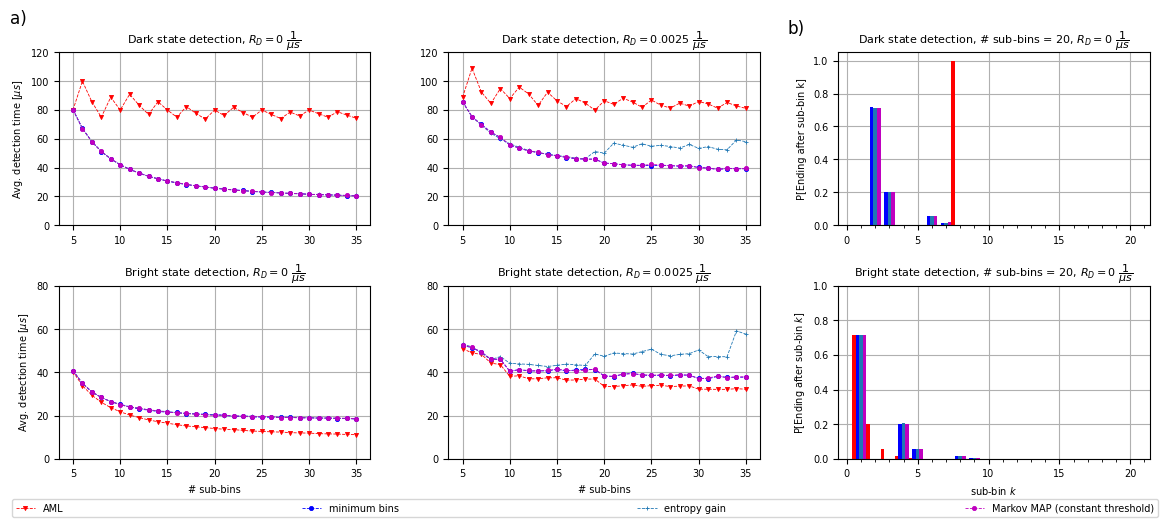

In [7]:
if plot_histogram == True:
    if plot_histogram_bkg:
        fig, axs = plt.subplots(2, 4)
    else:
        fig, axs = plt.subplots(2, 3)
    fig.set_size_inches(full_width * 2 , ratio_2_col * full_width)
else:
    fig, axs = plt.subplots(2, 2, sharex='all', sharey='row')
    fig.set_size_inches(full_width, ratio_2_col * full_width)
    
plt.rc('font', size=font_size)  
plt.rc('axes', titlesize=title_size)
#plot_title = 'Average detection times comparison ($e_c = 10^{-4}$)'

# get sub-bin numbers
n_subbins = df_avg.get('n_subbins').to_numpy()

# loop through estimators and plot all tests
for est in estimators_to_plot:
    axs[0, 0].plot(n_subbins, df_avg.get('t_avg/'+est+'/dark_R_D_0/').to_numpy(), label=label_dict.get(est), linewidth = linewidth, linestyle='--', color=color_dict.get(est), marker = marker_dict.get(est), markersize=markersize, mew=linewidth)
    axs[0, 1].plot(n_subbins, df_avg.get('t_avg/'+est+'/dark_R_D_0_5/').to_numpy(), linewidth = linewidth, linestyle='--', color=color_dict.get(est), marker = marker_dict.get(est), markersize=markersize, mew=linewidth)
    axs[1, 0].plot(n_subbins, df_avg.get('t_avg/'+est+'/bright_R_D_0/').to_numpy(), linewidth = linewidth, linestyle='--', color=color_dict.get(est), marker = marker_dict.get(est), markersize=markersize, mew=linewidth)
    axs[1, 1].plot(n_subbins, df_avg.get('t_avg/'+est+'/bright_R_D_0_5/').to_numpy(), linewidth = linewidth, linestyle='--', color=color_dict.get(est), marker = marker_dict.get(est), markersize=markersize, mew=linewidth)

# plot top left (dark detection R_D = 0)
axs[0, 0].set_title('Dark state detection, $R_D = 0 \ \dfrac{1}{\mu s}$')
axs[0, 0].set_ylabel('Avg. detection time $[\mu s$]')
axs[0, 0].set_xticks(np.arange(5, 36, 5))
axs[0, 0].set_yticks(np.arange(0, 140, 20))
axs[0, 0].text(-5.0/6.0 * 2, 7.0/6.0 * 120, 'a)', fontsize=axs_text_size)
axs[0, 0].grid('all')

# plot top right (dark detection R_D = 0.5)
axs[0, 1].set_title('Dark state detection, $R_D = 0.0025 \ \dfrac{1}{\mu s}$')
axs[0, 1].set_yticks(np.arange(0, 140, 20))
axs[0, 1].grid('all')

# plot bottom left (dark detection R_D = 0)
axs[1, 0].set_title('Bright state detection, $R_D = 0 \ \dfrac{1}{\mu s}$')
axs[1, 0].set_ylabel('Avg. detection time $[\mu s$]')
axs[1, 0].set_yticks(np.arange(0, 100, 20))
axs[1, 0].set_xlabel('# sub-bins')
axs[1, 0].grid('all')

# plot bottom right (dark detection R_D = 0.5)
axs[1, 1].set_title('Bright state detection, $R_D = 0.0025 \ \dfrac{1}{\mu s}$')
axs[1, 1].set_yticks(np.arange(0, 100, 20))
axs[1, 1].grid('all')
axs[1, 1].set_xlabel('# sub-bins')

if plot_histogram:
    #get sub-bin numbers
    subbin_k = df_hist.get('idx').to_numpy()

    # fun with indeces
    n_est = len(estimators_to_plot)
    bar_width = 1/(n_est)
    offset_start = -0.5 * n_est * bar_width


    for i, est in enumerate(estimators_to_plot):
        axs[0, 2].bar(subbin_k + offset_start + i*bar_width, df_hist.get('hist/'+est+'/dark/').to_numpy()/n_rep, color=color_dict.get(est), width=bar_width)
        axs[1, 2].bar(subbin_k + offset_start + i*bar_width, df_hist.get('hist/'+est+'/bright/').to_numpy()/n_rep, color=color_dict.get(est), width=bar_width)
        if plot_histogram_bkg:
            axs[0, 3].bar(subbin_k + offset_start + i*bar_width, df_hist.get('hist/'+est+'/dark_bkd/').to_numpy()/n_rep, color=color_dict.get(est), width=bar_width)
            axs[1, 3].bar(subbin_k + offset_start + i*bar_width, df_hist.get('hist/'+est+'/bright_bkd/').to_numpy()/n_rep, color=color_dict.get(est), width=bar_width)
    # plot top left (dark detection R_D = 0)
    axs[0, 2].set_title('Dark state detection, # sub-bins = 20, $R_D = 0 \ \dfrac{1}{\mu s}$')
    axs[0, 2].set_ylabel('P[Ending after sub-bin k]')
    axs[0, 2].xaxis.set_major_locator(MultipleLocator(5))
    axs[0, 2].xaxis.set_minor_locator(MultipleLocator(1))
    axs[0, 2].set_yticks(np.arange(0, 1.2, 0.2))
    axs[0, 2].text(-5.0/6.0 * 5, 7.0/6.0 * 1, 'b)', fontsize=axs_text_size)
    axs[0, 2].grid('all')
    axs[0, 2].set_axisbelow(True)

    # plot bottom left (bright detection R_D = 0)
    axs[1, 2].set_title('Bright state detection, # sub-bins = 20, $R_D = 0 \ \dfrac{1}{\mu s}$')
    axs[1, 2].xaxis.set_major_locator(MultipleLocator(5))
    axs[1, 2].xaxis.set_minor_locator(MultipleLocator(1))
    axs[1, 2].set_ylabel('P[Ending after sub-bin $k$]')
    axs[1, 2].set_xlabel('sub-bin $k$')
    axs[1, 2].set_yticks(np.arange(0, 1.2, 0.2))
    axs[1, 2].grid('all')
    axs[1, 2].set_axisbelow(True)
    if plot_histogram_bkg:
        # plot bottom right (bright detection R_D = 0.5)
        axs[1, 3].set_title('Bright state detection, # sub-bins = 20, $R_D = 0.0025 \ \dfrac{1}{\mu s}$')
        axs[1, 3].xaxis.set_major_locator(MultipleLocator(5))
        axs[1, 3].xaxis.set_minor_locator(MultipleLocator(1))
        axs[1, 3].set_yticks(np.arange(0, 1.2, 0.2))
        axs[1, 3].set_xlabel('sub-bin $k$')
        axs[1, 3].grid('all')
        axs[1, 3].set_axisbelow(True)
        
        # plot top right (dark detection R_D = 0.5)
        axs[0, 3].set_title('Dark state detection, # sub-bins = 20, $R_D = 0.0025 \ \dfrac{1}{\mu s}$')
        axs[0, 3].xaxis.set_major_locator(MultipleLocator(5))
        axs[0, 3].xaxis.set_minor_locator(MultipleLocator(1))
        axs[0, 3].set_yticks(np.arange(0, 1.2, 0.2))
        axs[0, 3].grid('all')
        axs[0, 3].set_axisbelow(True)

#fig.suptitle(plot_title)
fig.legend(loc='lower center', ncol=len(estimators_to_plot), columnspacing=24.5)
fig.subplots_adjust(wspace=0.25, hspace=0.35)
fig.savefig("avg_detection_times_" + test_set[test_set_idx] + ".pdf", bbox_inches='tight')

# Figure 4: Detection error. Estimator that has the same threshold (show it will never converge).
And then show the same but with the exponential growth of the threshold.

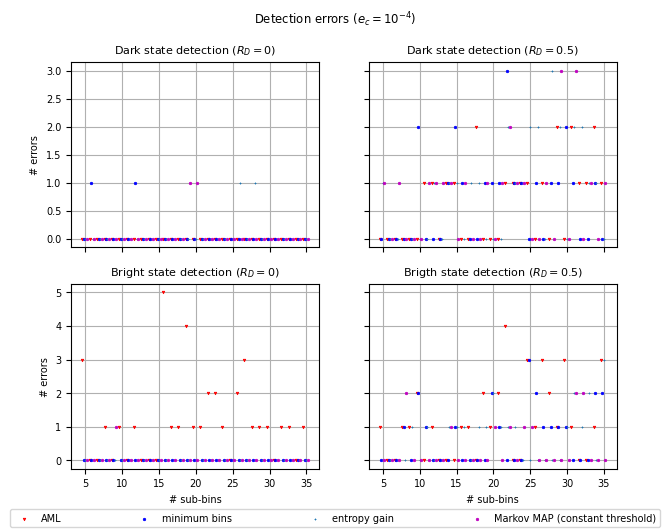

In [8]:
fig, axs = plt.subplots(2, 2, sharex='all', sharey='row')
fig.set_size_inches(full_width , ratio_2_col * full_width)
plt.rc('font', size=font_size)  
plt.rc('axes', titlesize=title_size)
plot_title = 'Detection errors ($e_c = 10^{-4}$)'

# get sub-bin numbers
n_subbins = df_avg.get('n_subbins').to_numpy()

# fun with indeces
n_est = len(estimators_to_plot)
if (n_est % 2 == 0):
    offset_start = -(np.floor((n_est+1)/2.0) / (n_est+1))
    inc = 1.0 / (n_est+1)
else:
    offset_start = -(np.floor(n_est/2.0) / n_est)
    inc = 1.0 / n_est
    
for i, est in enumerate(estimators_to_plot):
    axs[0, 0].scatter(n_subbins + offset_start + i * inc, df_avg.get('n_errors/'+est+'/dark_R_D_0/').to_numpy(), label=label_dict.get(est), linewidths=linewidth, color=color_dict.get(est), marker=marker_dict.get(est), s=markersize)
    axs[0, 1].scatter(n_subbins + offset_start + i * inc, df_avg.get('n_errors/'+est+'/dark_R_D_0_5/').to_numpy(), linewidths=linewidth, color=color_dict.get(est), marker=marker_dict.get(est), s=markersize)
    axs[1, 0].scatter(n_subbins + offset_start + i * inc, df_avg.get('n_errors/'+est+'/bright_R_D_0/').to_numpy(), linewidths=linewidth, color=color_dict.get(est), marker=marker_dict.get(est), s=markersize)
    axs[1, 1].scatter(n_subbins + offset_start + i * inc, df_avg.get('n_errors/'+est+'/bright_R_D_0_5/').to_numpy(), linewidths=linewidth, color=color_dict.get(est), marker=marker_dict.get(est), s=markersize)

# plot top left (dark detection R_D = 0)
axs[0, 0].set_title('Dark state detection ($R_D = 0$)')
axs[0, 0].set_ylabel('')
axs[0, 0].set_xticks(np.arange(5, 36, 5))
axs[0, 0].set_ylabel('# errors')
axs[0, 0].grid('row')
axs[0, 0].set_axisbelow(True)
# top right (dark detection R_D = 0.5)
axs[0, 1].set_title('Dark state detection ($R_D = 0.5$)')
axs[0, 1].grid('row')
axs[0, 1].set_axisbelow(True)

# bottom left (bright detection R_D = 0)
axs[1, 0].set_title('Bright state detection ($R_D = 0$)')
axs[1, 0].grid('row')
axs[1, 0].set_ylabel('# errors')
axs[1, 0].set_xlabel('# sub-bins')
axs[1, 0].set_axisbelow(True)
# bottom right (bright detection R_D = 0.5)
axs[1, 1].set_title('Brigth state detection ($R_D = 0.5$)')
axs[1, 1].grid('row')
axs[1, 1].set_axisbelow(True)
axs[1, 1].set_xlabel('# sub-bins')

fig.legend(loc='lower center', ncol=n_est, columnspacing=legend_width / n_est)

fig.suptitle(plot_title)
fig.savefig("errors_" + test_set[test_set_idx] + ".pdf", bbox_inches='tight')

# Figure S1: in the appendix. plot of adaptive maximum likelihood for dark and bright (zig-zag dark)

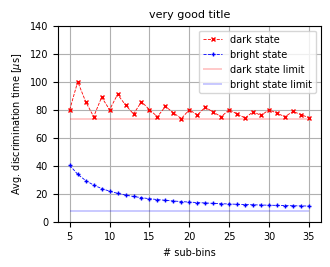

In [9]:
n_bins = np.arange(5, 36, 1)
t_det_tot = 200 # us
R_D = 0 / t_det_tot # per us
R_B = 25 / t_det_tot # per us
e_c = 1e-4
beta_c = np.log((1 - e_c)/(e_c))

t_bin = t_det_tot/n_bins

t_avg_dark = t_bin * np.ceil(beta_c * (1 / (t_bin * R_B)))
t_avg_bright = t_bin / (1 - np.exp(-t_bin * R_B))

t_avg_dark_lim = beta_c / R_B
t_avg_bright_lim = 1 / R_B


# plot settings
plt.rc('font', size=font_size)  
plt.rc('axes', titlesize=title_size)
plt.figure(figsize=(column_width,0.75 * column_width))
plot_title = 'very good title'
plot_limits=True

# actual plotting
## predictions
plt.plot(n_bins, t_avg_dark, color='r', marker='x', linewidth = linewidth, linestyle='--', markersize=markersize, label='dark state', zorder=3)
plt.plot(n_bins, t_avg_bright, color='b', marker='+',linewidth = linewidth, linestyle='--', markersize=markersize, label='bright state', zorder=3)

## limits
if plot_limits:
    plt.hlines(t_avg_dark_lim, 5, 35, color='r', linewidth=linewidth/2, linestyle='-', label='dark state limit')
    plt.hlines(t_avg_bright_lim, 5, 35, color='b', linewidth=linewidth/2, linestyle='-', label='bright state limit')

# axis and settings
plt.xlabel('# sub-bins')
plt.xticks(np.arange(5, 36, 5))
plt.yticks(np.arange(0, 160, 20))
plt.ylabel('Avg. discrimination time [$\mu$s]')
plt.title(plot_title)
plt.grid('all', zorder=0.5)
plt.legend()

plt.savefig("figS1.pdf", bbox_inches='tight')

# Figure S2: A histogram plot that shows the distribution of number of bins used.

In [10]:
# load data from csv
n_subbins = 20
test_set_idx = 0
if test_set_idx == 0:
    n_rep = 100000
    filename = test_set[test_set_idx] + '_histogram_n='+str(n_subbins)+'_N=100000.csv'
else:
    filename = test_set[test_set_idx] + '_histogram_n='+str(n_subbins)+'_N=20000.csv'
    n_rep = 20000
df = pd.read_csv(path + filename)
print(df.columns)

Index(['Unnamed: 0', 'idx', 'hist/hmm/dark_bkd/', 'hist/hmm_no_exp/dark_bkd/',
       'hist/entropy_gain/dark_bkd/', 'hist/minbins/dark_bkd/',
       'hist/aml/dark_bkd/', 'hist/hmm/dark/', 'hist/hmm_no_exp/dark/',
       'hist/entropy_gain/dark/', 'hist/minbins/dark/', 'hist/aml/dark/',
       'hist/hmm/bright_bkd/', 'hist/hmm_no_exp/bright_bkd/',
       'hist/entropy_gain/bright_bkd/', 'hist/minbins/bright_bkd/',
       'hist/aml/bright_bkd/', 'hist/hmm/bright/', 'hist/hmm_no_exp/bright/',
       'hist/entropy_gain/bright/', 'hist/minbins/bright/',
       'hist/aml/bright/'],
      dtype='object')


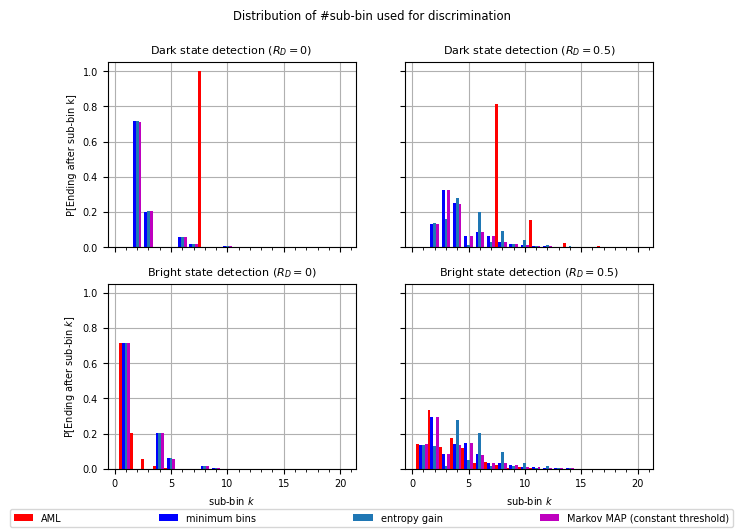

In [11]:
fig, axs = plt.subplots(2, 2, sharex='all', sharey='all')
fig.set_size_inches(full_width , ratio_2_col * full_width)
plt.rc('font', size=font_size)  
plt.rc('axes', titlesize=title_size)
plot_title = 'Distribution of #sub-bin used for discrimination'

#get sub-bin numbers
subbin_k = df.get('idx').to_numpy()
# fun with indeces
n_est = len(estimators_to_plot)
bar_width = 1/(n_est)
offset_start = -0.5 * n_est * bar_width

    
for i, est in enumerate(estimators_to_plot):
    if test_set_idx == 0:
        axs[0, 0].bar(subbin_k + offset_start + i*bar_width, df.get('hist/'+est+'/dark/').to_numpy()/n_rep, label=label_dict.get(est), color=color_dict.get(est), width=bar_width)
        axs[0, 1].bar(subbin_k + offset_start + i*bar_width, df.get('hist/'+est+'/dark_bkd/').to_numpy()/n_rep, color=color_dict.get(est), width=bar_width)
        axs[1, 0].bar(subbin_k + offset_start + i*bar_width, df.get('hist/'+est+'/bright/').to_numpy()/n_rep, color=color_dict.get(est), width=bar_width)
        axs[1, 1].bar(subbin_k + offset_start + i*bar_width, df.get('hist/'+est+'/bright_bkd/').to_numpy()/n_rep, color=color_dict.get(est), width=bar_width)     
    else:
        axs[0, 0].bar(subbin_k + offset_start + i*bar_width, df.get('hist/'+est+'/dark_R_D_0/').to_numpy()/n_rep, label=label_dict.get(est), color=color_dict.get(est), width=bar_width)
        axs[0, 1].bar(subbin_k + offset_start + i*bar_width, df.get('hist/'+est+'/dark_R_D_0_5/').to_numpy()/n_rep, color=color_dict.get(est), width=bar_width)
        axs[1, 0].bar(subbin_k + offset_start + i*bar_width, df.get('hist/'+est+'/bright_R_D_0/').to_numpy()/n_rep, color=color_dict.get(est), width=bar_width)
        axs[1, 1].bar(subbin_k + offset_start + i*bar_width, df.get('hist/'+est+'/bright_R_D_0_5/').to_numpy()/n_rep, color=color_dict.get(est), width=bar_width)
# plot top left (dark detection R_D = 0)
axs[0, 0].set_title('Dark state detection ($R_D = 0$)')
axs[0, 0].set_ylabel('P[Ending after sub-bin k]')
axs[0, 0].set_yticks(np.arange(0, 1.2, 0.2))
axs[0, 0].grid('all')
axs[0, 0].set_axisbelow(True)

# plot top right (dark detection R_D = 0.5)
axs[0, 1].set_title('Dark state detection ($R_D = 0.5$)')
axs[0, 1].grid('all')
axs[0, 1].set_axisbelow(True)

# plot bottom left (bright detection R_D = 0)
axs[1, 0].set_title('Bright state detection ($R_D = 0$)')
axs[1, 0].set_ylabel('P[Ending after sub-bin $k$]')
axs[1, 0].set_xlabel('sub-bin $k$')
axs[1, 0].grid('all')
axs[1, 0].set_axisbelow(True)

# plot bottom right (bright detection R_D = 0.5)
axs[1, 1].set_title('Bright state detection ($R_D = 0.5$)')
axs[1, 1].xaxis.set_major_locator(MultipleLocator(5))
axs[1, 1].xaxis.set_minor_locator(MultipleLocator(1))
axs[1, 1].set_xlabel('sub-bin $k$')
axs[1, 1].grid('all')
axs[1, 1].set_axisbelow(True)

fig.legend(loc='lower center', ncol=len(estimators_to_plot), columnspacing=legend_column_spacing)
fig.suptitle(plot_title)

fig.savefig("histogram_"+ test_set[test_set_idx] + "_n=" + str(n_subbins) + '.pdf', bbox_inches='tight')

# Figure S3: fidelity as a function of pi pulse errors

In [12]:
# load data from csv
n_subbins = 20
filename = 'pi_success.csv'
df = pd.read_csv(path + filename)
print(df.columns)

Index(['Unnamed: 0', 'p_success', 'n_pi_avg/entropy_gain/dark_R_D_0_5/',
       'fidelity/entropy_gain/dark_R_D_0_5/',
       't_avg/entropy_gain/dark_R_D_0_5/', 'n_pi_avg/minbins/dark_R_D_0_5/',
       'fidelity/minbins/dark_R_D_0_5/', 't_avg/minbins/dark_R_D_0_5/',
       'n_pi_avg/hmm_no_exp/dark_R_D_0_5/',
       'fidelity/hmm_no_exp/dark_R_D_0_5/', 't_avg/hmm_no_exp/dark_R_D_0_5/',
       'n_pi_avg/hmm/dark_R_D_0_5/', 'fidelity/hmm/dark_R_D_0_5/',
       't_avg/hmm/dark_R_D_0_5/', 'n_pi_avg/entropy_gain/dark_R_D_0/',
       'fidelity/entropy_gain/dark_R_D_0/', 't_avg/entropy_gain/dark_R_D_0/',
       'n_pi_avg/minbins/dark_R_D_0/', 'fidelity/minbins/dark_R_D_0/',
       't_avg/minbins/dark_R_D_0/', 'n_pi_avg/hmm_no_exp/dark_R_D_0/',
       'fidelity/hmm_no_exp/dark_R_D_0/', 't_avg/hmm_no_exp/dark_R_D_0/',
       'n_pi_avg/hmm/dark_R_D_0/', 'fidelity/hmm/dark_R_D_0/',
       't_avg/hmm/dark_R_D_0/', 'n_pi_avg/entropy_gain/bright_R_D_0_5/',
       'fidelity/entropy_gain/bright_R_D_0

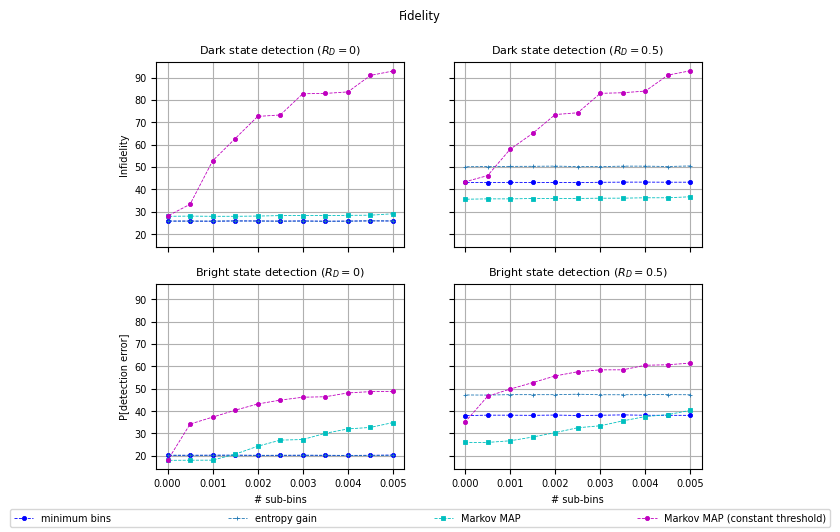

In [13]:
fig, axs = plt.subplots(2, 2, sharex='all', sharey='all')
fig.set_size_inches(full_width , ratio_2_col * full_width)
plt.rc('font', size=font_size)  
plt.rc('axes', titlesize=title_size)
plot_title = 'Fidelity'
data_to_plot = 't_avg/'
estimators_to_plot = ['minbins', 'entropy_gain', 'hmm', 'hmm_no_exp']
# get sub-bin numbers
p_success = df.get('p_success').to_numpy()

for i, est in enumerate(estimators_to_plot):
    axs[0, 0].plot(1-p_success, df.get(data_to_plot+est+'/dark_R_D_0/').to_numpy(), label=label_dict.get(est), linewidth = linewidth, linestyle='--', color=color_dict.get(est), marker = marker_dict.get(est), markersize=markersize, mew=linewidth)
    axs[0, 1].plot(1-p_success, df.get(data_to_plot+est+'/dark_R_D_0_5/').to_numpy(), linewidth = linewidth, linestyle='--', color=color_dict.get(est), marker = marker_dict.get(est), markersize=markersize, mew=linewidth)
    axs[1, 0].plot(1-p_success, df.get(data_to_plot+est+'/bright_R_D_0/').to_numpy(), linewidth = linewidth, linestyle='--', color=color_dict.get(est), marker = marker_dict.get(est), markersize=markersize, mew=linewidth)
    axs[1, 1].plot(1-p_success, df.get(data_to_plot+est+'/bright_R_D_0_5/').to_numpy(), linewidth = linewidth, linestyle='--', color=color_dict.get(est), marker = marker_dict.get(est), markersize=markersize, mew=linewidth)


# plot top left (dark detection R_D = 0)
axs[0, 0].set_title('Dark state detection ($R_D = 0$)')
axs[0, 0].set_ylabel('Infidelity')
axs[0, 0].grid('all')

# plot top right (dark detection R_D = 0.5)
axs[0, 1].set_title('Dark state detection ($R_D = 0.5$)')
axs[0, 1].grid('all')

# plot bottom left (dark detection R_D = 0)
axs[1, 0].set_title('Bright state detection ($R_D = 0$)')
axs[1, 0].set_ylabel('P[detection error]')
axs[1, 0].set_xlabel('# sub-bins')
axs[1, 0].grid('all')

# plot bottom right (dark detection R_D = 0.5)
axs[1, 1].set_title('Bright state detection ($R_D = 0.5$)')
#axs[1, 1].set_yticks(np.arange(0, 0.0125, 0.0025))
axs[1, 1].grid('all')
axs[1, 1].set_xlabel('# sub-bins')
fig.legend(loc='lower center', ncol=len(estimators_to_plot), columnspacing=12)

fig.suptitle(plot_title)
fig.savefig("p_success_vs_fidelity.pdf", bbox_inches='tight')

# Figure S4: average number of pi plots.

here


Text(0.5, 0.98, 'Average #$\\pi$-pulses')

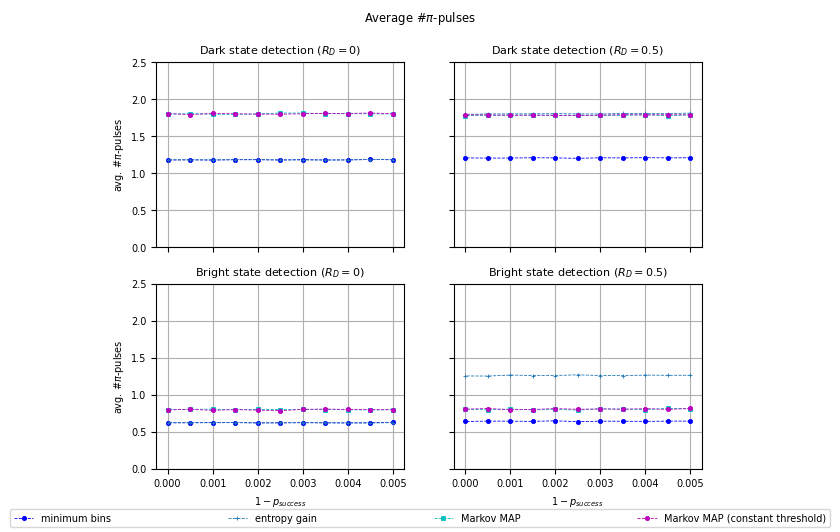

In [14]:
fig, axs = plt.subplots(2, 2, sharex='all', sharey='all')
fig.set_size_inches(full_width , ratio_2_col * full_width)
plt.rc('font', size=font_size)  
plt.rc('axes', titlesize=title_size)
data_to_plot = 'n_pi_avg/'
if (data_to_plot == 'n_pi_avg/'):
    print('here')
    plot_title = 'Average #$\pi$-pulses'
    y_label = 'avg. #$\pi$-pulses'
    y_ticks_top = np.arange(0, 3, 0.5)
    y_ticks_bottom = np.arange(0, 3, 0.5)
else:
    plot_title = 'a very good title'
    y_ticks_top = np.arange(0, 25, 0.5)
    y_ticks_bottom = np.arange(0, 25, 0.5)
# get sub-bin numbers
p_success = df.get('p_success').to_numpy()

for i, est in enumerate(estimators_to_plot):
    axs[0, 0].plot(1-p_success, df.get(data_to_plot+est+'/dark_R_D_0/').to_numpy(), label=label_dict.get(est), linewidth = linewidth, linestyle='--', color=color_dict.get(est), marker = marker_dict.get(est), markersize=markersize, mew=linewidth)
    axs[0, 1].plot(1-p_success, df.get(data_to_plot+est+'/dark_R_D_0_5/').to_numpy(), linewidth = linewidth, linestyle='--', color=color_dict.get(est), marker = marker_dict.get(est), markersize=markersize, mew=linewidth)
    axs[1, 0].plot(1-p_success, df.get(data_to_plot+est+'/bright_R_D_0/').to_numpy(), linewidth = linewidth, linestyle='--', color=color_dict.get(est), marker = marker_dict.get(est), markersize=markersize, mew=linewidth)
    axs[1, 1].plot(1-p_success, df.get(data_to_plot+est+'/bright_R_D_0_5/').to_numpy(), linewidth = linewidth, linestyle='--', color=color_dict.get(est), marker = marker_dict.get(est), markersize=markersize, mew=linewidth)


# plot top left (dark detection R_D = 0)
axs[0, 0].set_title('Dark state detection ($R_D = 0$)')
axs[0, 0].set_ylabel(y_label)
axs[0, 0].set_yticks(y_ticks_top)
axs[0, 0].grid('all')

# plot top right (dark detection R_D = 0.5)
axs[0, 1].set_title('Dark state detection ($R_D = 0.5$)')
axs[0, 1].grid('all')

# plot bottom left (bright detection R_D = 0)
axs[1, 0].set_title('Bright state detection ($R_D = 0$)')
axs[1, 0].set_ylabel(y_label)
axs[1, 0].set_yticks(y_ticks_bottom)
axs[1, 0].set_xlabel('$1 - p_{success}$')
axs[1, 0].grid('all')

# plot bottom right (right detection R_D = 0.5)
axs[1, 1].set_title('Bright state detection ($R_D = 0.5$)')
axs[1, 1].grid('all')
axs[1, 1].set_xlabel('$1 - p_{success}$')
fig.legend(loc='lower center', ncol=len(estimators_to_plot), columnspacing=12)

fig.suptitle(plot_title)

# Pi pulse histogram

In [15]:
# load data from csv
n_subbins = 20
filename = 'trajectory_analysis_histogram.csv'
df = pd.read_csv(path + filename)
print(df.columns)

estimator_list = ['hmm', 'entropy_gain', 'minbins']
test_list = ['/dark/', '/bright/']

Index(['Unnamed: 0', 'subbin_idx', 'n_pi_pulse/hmm/dark_bkd/',
       'n_estimator/hmm/dark_bkd/', 'n_pi_pulse/hmm_no_exp/dark_bkd/',
       'n_estimator/hmm_no_exp/dark_bkd/', 'n_pi_pulse/entropy_gain/dark_bkd/',
       'n_estimator/entropy_gain/dark_bkd/', 'n_pi_pulse/minbins/dark_bkd/',
       'n_estimator/minbins/dark_bkd/', 'n_pi_pulse/hmm/dark/',
       'n_estimator/hmm/dark/', 'n_pi_pulse/hmm_no_exp/dark/',
       'n_estimator/hmm_no_exp/dark/', 'n_pi_pulse/entropy_gain/dark/',
       'n_estimator/entropy_gain/dark/', 'n_pi_pulse/minbins/dark/',
       'n_estimator/minbins/dark/', 'n_pi_pulse/hmm/bright_bkd/',
       'n_estimator/hmm/bright_bkd/', 'n_pi_pulse/hmm_no_exp/bright_bkd/',
       'n_estimator/hmm_no_exp/bright_bkd/',
       'n_pi_pulse/entropy_gain/bright_bkd/',
       'n_estimator/entropy_gain/bright_bkd/',
       'n_pi_pulse/minbins/bright_bkd/', 'n_estimator/minbins/bright_bkd/',
       'n_pi_pulse/hmm/bright/', 'n_estimator/hmm/bright/',
       'n_pi_pulse/hmm_no_

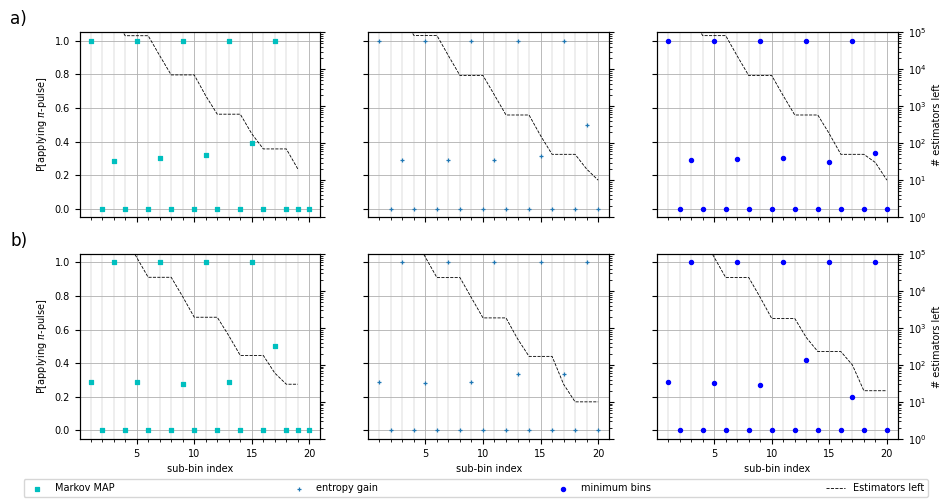

In [16]:
fig, axs = plt.subplots(2, 3, sharex='all', sharey='all')
fig.set_size_inches(1.5*full_width, ratio_2_col * full_width)
plt.rc('font', size=font_size)  
plt.rc('axes', titlesize=title_size)
subbin_k = df.get('subbin_idx').to_numpy()

for i, est in enumerate(estimator_list):
    # calculate pi pulse probability
    for j, test in enumerate(test_list):
        n_estimator = df.get('n_estimator/' + est + test).to_numpy()
        n_pi = df.get('n_pi_pulse/' + est + test).to_numpy()
        # get indices where devision is possible
        idx_non_zero_est = np.argwhere(n_estimator > 0)
        probab_pi = np.zeros(subbin_k[-1])
        probab_pi[idx_non_zero_est] = n_pi[idx_non_zero_est] / n_estimator[idx_non_zero_est]
        
        # hack for plotting issues...
        # last population
        if(n_estimator[np.max(idx_non_zero_est)] > 1 and np.max(idx_non_zero_est)<n_subbins-1):
            # set the next population to one such that it plots the line to the limits of the graph
            n_estimator[np.max(idx_non_zero_est)+1] = 1
        
        # add estimator once when the estimator is first added to the figure...
        label_i = label_dict.get(est)
        if j>0:
            label_i = None
        
        axs[j, i].scatter(subbin_k, probab_pi, label=label_i, s=markersize*3, linewidths=linewidth*1.5, color=color_dict.get(est), marker = marker_dict.get(est), zorder=10)
        axs[j, i].grid(linewidth=linewidth, which='major', axis='both', zorder=12)
        axs[j, i].grid(linewidth=linewidth/2, which='minor', axis='x', zorder=11)
        # plot estimator population
        secax_y = axs[j, i].twinx()
        if (i == 0 and j == 0):
            label_i = 'Estimators left'
        else:
            label_i = None
        secax_y.semilogy(subbin_k[idx_non_zero_est], n_estimator[idx_non_zero_est], label = label_i, linewidth = linewidth, linestyle='--', color='black')
        secax_y.axis(ymin=1, ymax=1e5)
        #secax_y.set_ylabel('# estimators left')
        # set label for probability of applying pulse
        # first column
        if i == 0:
            axs[j, i].set_ylabel('P[applying $\pi$-pulse]')
            text='a)'
            if j == 1:
                text='b)'
            axs[j, i].text(-6, 1.1, text, fontsize=axs_text_size)
        # set label for estimator population
        # last column
        if i == len(estimator_list) - 1:
            secax_y.set_ylabel('# estimators left')
        #every other column
        else:
            secax_y.yaxis.set_ticklabels([])
        if j == 1:
            axs[j, i].set_xlabel('sub-bin index')
        
axs[0, 0].xaxis.set_major_locator(MultipleLocator(5))
axs[0, 0].xaxis.set_minor_locator(MultipleLocator(1))
fig.legend(loc='lower center', ncol=len(estimator_list) + 1, columnspacing=18)
fig.savefig("p_pi_pulse_vs_subbin_idx.pdf", bbox_inches='tight')

In [17]:
print(np.logspace(1, 6, num=6, base=10, endpoint=True))

[1.e+01 1.e+02 1.e+03 1.e+04 1.e+05 1.e+06]
